In [1]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import seaborn as sns
import shutil

from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.ensemble import RandomForestClassifier

In [2]:
# train_path = "/Users/srikanth.goli/Downloads/kneeKL224Sample/train"
# test_path = "/Users/srikanth.goli/Downloads/kneeKL224Sample/test"
# valid_path = "/Users/srikanth.goli/Downloads/kneeKL224Sample/val"
train_path = "/Users/srikanth.goli/Downloads/KneeXrayData/ClsKLData/kneeKL299/train"
test_path = "/Users/srikanth.goli/Downloads/KneeXrayData/ClsKLData/kneeKL299/test"
valid_path = "/Users/srikanth.goli/Downloads/KneeXrayData/ClsKLData/kneeKL299/val"

list_of_classes = ['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']
for d in [train_path, test_path, valid_path]:
    filepaths = []
    labels = [] 
    classlist = os.listdir(d)
    for klass in classlist:
        intklass = int(klass)
        label = list_of_classes[intklass]
        classpath = os.path.join(d, klass)
        flist = os.listdir(classpath)        
        for f in flist:
            fpath = os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(label)
    Fseries = pd.Series(filepaths, name = 'filepaths')
    Lseries = pd.Series(labels, name = 'labels')        
    pdf = pd.concat([Fseries, Lseries], axis=1)
    if d == test_path:
        test_df = pdf
    elif d == valid_path:
        valid_df = pdf
    else:
        train_df = pdf

print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

# get the number of classes and the images count for each class in train_df
classes = sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups = train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist = []
classlist = []
for label in sorted(list(train_df['labels'].unique())):
    group = groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# lets get the average height and width of a sample of the train images
ht = 0
wt = 0

train_df_sample = train_df.sample(n = 100, random_state = 123, axis = 0)
for i in range (len(train_df_sample)):
    fpath = train_df_sample['filepaths'].iloc[i]
    img = plt.imread(fpath)
    shape = img.shape
    ht += shape[0]
    wt += shape[1]

train_df length:  7304   test_df length:  1656   valid_df length:  826
The number of classes in the dataset is:  5
            CLASS               IMAGE COUNT 
           Doubtful                1321     
           Healthy                 2890     
           Minimal                 1919     
           Moderate                 957     
            Severe                  217     


In [3]:
# image size - avg hight and width
average_height = ht // 100
average_width = wt // 100
image_size = (average_height, average_width)

# preprocess images
def preprocess(filepaths):
    images = []
    for filepath in filepaths:
        img = plt.imread(filepath)
        img = resize(img, image_size, anti_aliasing=True)
        img_flat = img.flatten()
        images.append(img_flat)
    return images

In [4]:
train_images = preprocess(train_df['filepaths'])
test_images = preprocess(test_df['filepaths'])
valid_images = preprocess(valid_df['filepaths'])

In [5]:
# label encoding 
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df['labels'])
test_labels = label_encoder.transform(test_df['labels'])
valid_labels = label_encoder.transform(valid_df['labels'])

In [6]:
# Best Hyperparameters: {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}

svm = SVC(kernel = 'poly', probability=True, C = 0.1)#decision_function_shape='ovo'
# C=1.0, kernel=’rbf’, degree=3, gamma=’auto’
svm.fit(train_images, train_labels)

test_predictions = svm.predict(test_images)
accuracy = accuracy_score(test_labels, test_predictions)
report = classification_report(test_labels, test_predictions, target_names = list_of_classes)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

Accuracy: 0.4855072463768116
Classification Report:
               precision    recall  f1-score   support

     Healthy       0.18      0.01      0.02       296
    Doubtful       0.49      0.88      0.63       639
     Minimal       0.45      0.33      0.38       447
    Moderate       0.53      0.33      0.40       223
      Severe       0.68      0.41      0.51        51

    accuracy                           0.49      1656
   macro avg       0.46      0.39      0.39      1656
weighted avg       0.43      0.49      0.42      1656



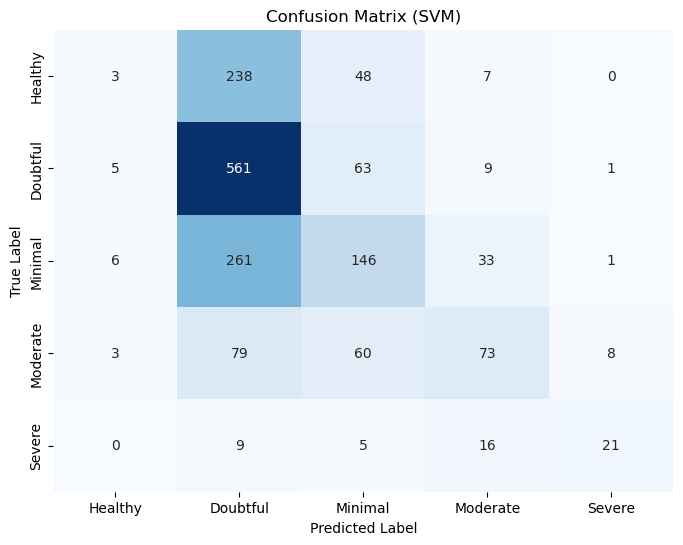

In [7]:
matrix_svm = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix_svm, annot=True, cmap = "Blues", fmt="d", cbar=False,
            xticklabels=list_of_classes, yticklabels=list_of_classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (SVM)")
plt.show()

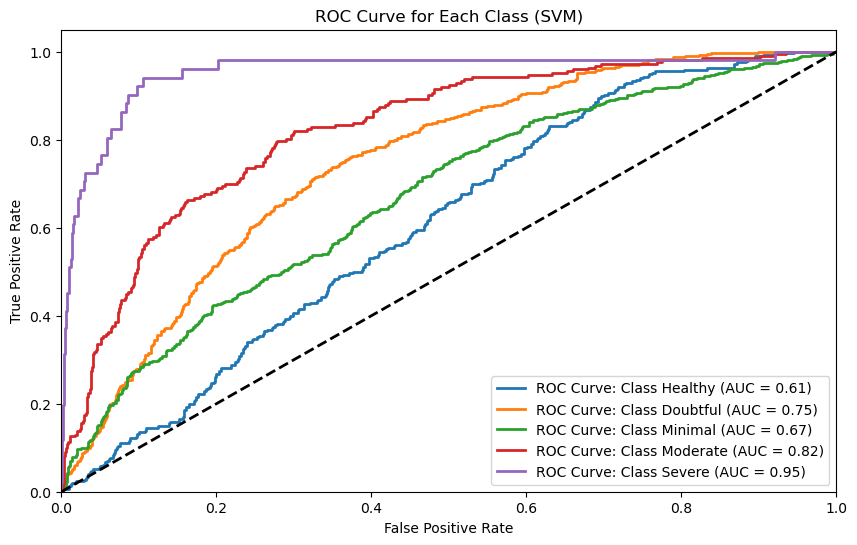

In [8]:
decision_function = svm.decision_function(test_images)
train_labels_binary = label_binarize(test_labels, classes=np.unique(train_labels))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(train_labels))):
    fpr[i], tpr[i], _ = roc_curve(train_labels_binary[:, i], decision_function[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(10, 6))
for i in range(len(np.unique(train_labels))):
    x = ""
    if i == 0:
        x = "Healthy"
    elif i == 1:
        x = "Doubtful"
    elif i == 2:
        x = "Minimal"
    elif i == 3:
        x = "Moderate"
    else:
        x = "Severe"
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC Curve: Class {} (AUC = {:.2f})'.format(x, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class (SVM)')
plt.legend(loc='lower right')
plt.show()

In [9]:
sensitivity_svm = matrix_svm.diagonal() / matrix_svm.sum(axis=1)
specificity_svm = np.diagonal(matrix_svm[::-1, ::-1]) / matrix_svm[::-1, ::-1].sum(axis=1)

sensitivity_heatmap_svm = np.array([sensitivity_svm])
specificity_heatmap_svm = np.array([specificity_svm])

In [10]:
from sklearn.linear_model import LogisticRegression

# changed max_iter from 1000 to 2000 but didn't fix the problem
logreg = LogisticRegression(max_iter = 2000, random_state = 123)
logreg.fit(train_images, train_labels)
test_predictions = logreg.predict(test_images)
accuracy = accuracy_score(test_labels, test_predictions)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(test_labels, test_predictions, target_names=list_of_classes))

/Users/srikanth.goli/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.46316425120772947
Classification Report:
              precision    recall  f1-score   support

     Healthy       0.22      0.13      0.16       296
    Doubtful       0.53      0.67      0.60       639
     Minimal       0.40      0.38      0.39       447
    Moderate       0.50      0.46      0.48       223
      Severe       0.55      0.55      0.55        51

    accuracy                           0.46      1656
   macro avg       0.44      0.44      0.43      1656
weighted avg       0.44      0.46      0.45      1656



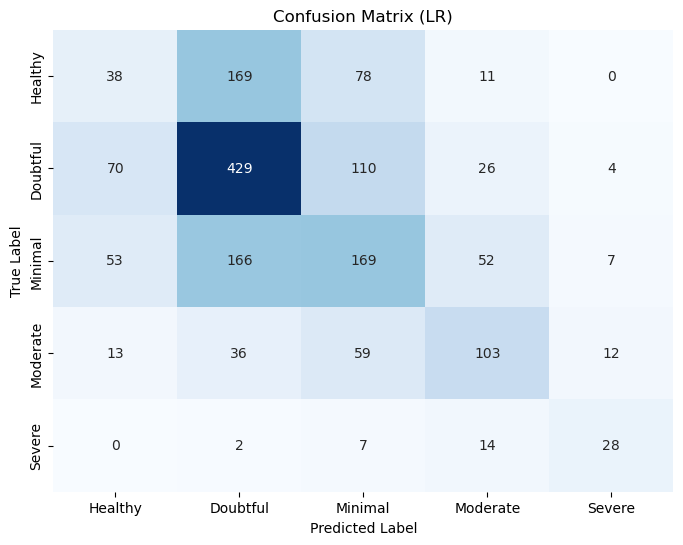

In [11]:
matrix_lr = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix_lr, annot=True, cmap = "Blues", fmt="d", cbar=False,
            xticklabels=list_of_classes, yticklabels=list_of_classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (LR)")
plt.show()

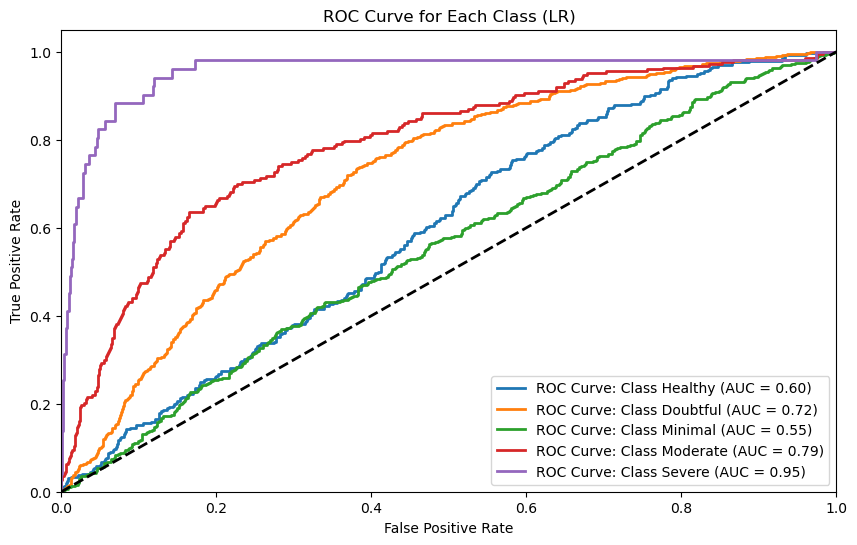

In [12]:
decision_function = logreg.decision_function(test_images)
test_labels_binary = label_binarize(test_labels, classes=np.unique(train_labels))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(train_labels))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_binary[:, i], decision_function[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
for i in range(len(np.unique(train_labels))):
    x = ""
    if i == 0:
        x = "Healthy"
    elif i == 1:
        x = "Doubtful"
    elif i == 2:
        x = "Minimal"
    elif i == 3:
        x = "Moderate"
    else:
        x = "Severe"
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC Curve: Class {} (AUC = {:.2f})'.format(x, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class (LR)')
plt.legend(loc='lower right')
plt.show()

In [13]:
sensitivity_lr = matrix_lr.diagonal() / matrix_lr.sum(axis=1)
specificity_lr = np.diagonal(matrix_lr[::-1, ::-1]) / matrix_lr[::-1, ::-1].sum(axis=1)

sensitivity_heatmap_lr = np.array([sensitivity_lr])
specificity_heatmap_lr = np.array([specificity_lr])

In [14]:
rf = RandomForestClassifier(n_estimators=100, random_state=123)
rf.fit(train_images, train_labels)
testrf_predictions = rf.predict(test_images)

accuracy = accuracy_score(test_labels, testrf_predictions)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(test_labels, testrf_predictions, target_names=list_of_classes))

Accuracy: 0.501207729468599
Classification Report:
              precision    recall  f1-score   support

     Healthy       0.60      0.11      0.19       296
    Doubtful       0.50      0.89      0.64       639
     Minimal       0.47      0.41      0.44       447
    Moderate       0.62      0.18      0.28       223
      Severe       0.75      0.06      0.11        51

    accuracy                           0.50      1656
   macro avg       0.59      0.33      0.33      1656
weighted avg       0.53      0.50      0.44      1656



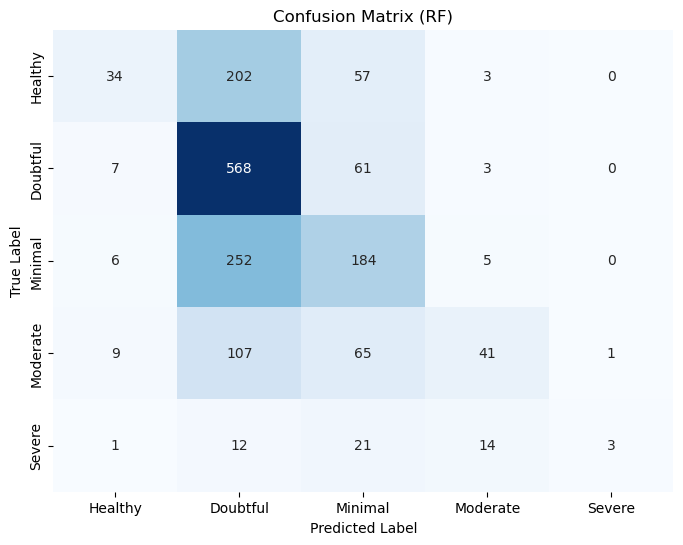

In [15]:
matrix_rf = confusion_matrix(test_labels, testrf_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix_rf, annot=True, cmap = "Blues", fmt="d", cbar=False,
            xticklabels=list_of_classes, yticklabels=list_of_classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (RF)")
plt.show()

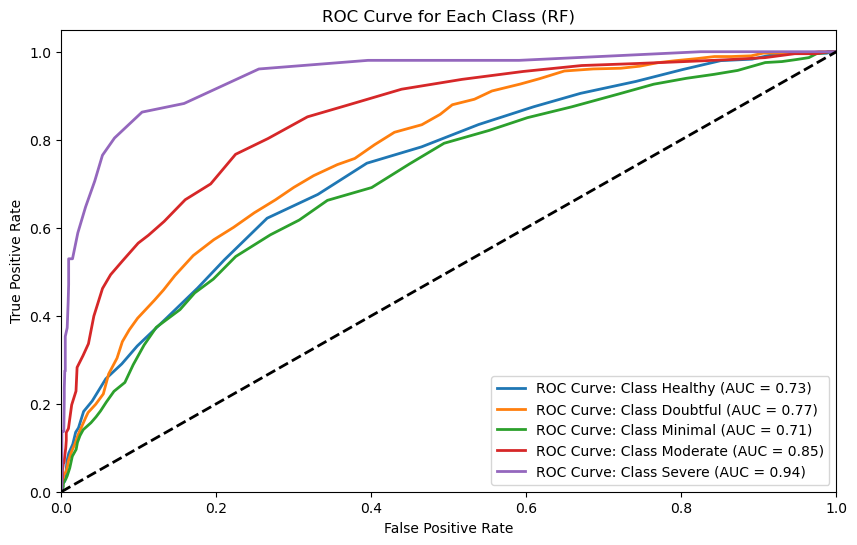

In [16]:
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

rf_decision_function = rf.predict_proba(test_images)
test_labels_binary = label_binarize(test_labels, classes=np.unique(train_labels))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(np.unique(train_labels))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_binary[:, i], rf_decision_function[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
for i in range(len(np.unique(train_labels))):
    x = ""
    if i == 0:
        x = "Healthy"
    elif i == 1:
        x = "Doubtful"
    elif i == 2:
        x = "Minimal"
    elif i == 3:
        x = "Moderate"
    else:
        x = "Severe"
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC Curve: Class {} (AUC = {:.2f})'.format(x, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class (RF)')
plt.legend(loc='lower right')
plt.show()


In [17]:
sensitivity_rf = matrix_rf.diagonal() / matrix_rf.sum(axis=1)
specificity_rf = np.diagonal(matrix_rf[::-1, ::-1]) / matrix_rf[::-1, ::-1].sum(axis=1)

sensitivity_heatmap_rf = np.array([sensitivity_rf])
specificity_heatmap_rf = np.array([specificity_rf])

# Sensitivity Chart

/var/folders/4j/hpmfkq9n6bz2s36bg0wbxw040000gn/T/ipykernel_33595/1549827869.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


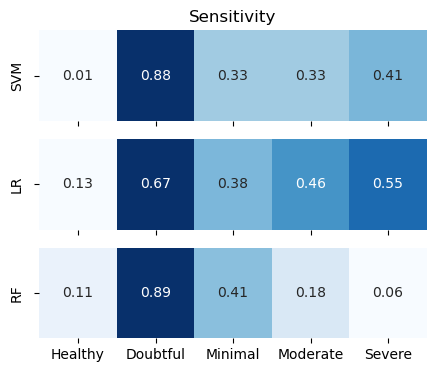

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 5,4

def plot_sensitivity_chart(data, class_names, title):
    
    svm_model, svm_y_axis = data[0]
    lr_model, lr_y_axis = data[1]
    rf_model, rf_y_axis = data[2]
    
    xlabel = ''
    
    svm = pd.DataFrame(svm_model, index=[xlabel], columns=[None, None, None, None, None])
    lr = pd.DataFrame(lr_model, index=[xlabel], columns=[None, None, None, None, None])
    rf = pd.DataFrame(rf_model, index=[xlabel], columns=class_names)
   #  plt.figure(figsize=(4, 4))
    
    fig, ax =plt.subplots(3,1)
    
    #sns.set_theme(rc={'figure.figsize':(20,40)})

    smv_chart = sns.heatmap(svm, annot=True, fmt='.2f', cmap='Blues', cbar=False, ax=ax[0])
    smv_chart.get_yaxis().set_label_text('SVM')
    smv_chart.set_title('Sensitivity')
    
    
    lr_chart = sns.heatmap(lr, annot=True, fmt='.2f', cmap='Blues', cbar=False, ax=ax[1])
    lr_chart.get_yaxis().set_label_text('LR')
    
    
    rf_chart = sns.heatmap(rf, annot=True, fmt='.2f', cmap='Blues', cbar=False, ax=ax[2])
    rf_chart.get_yaxis().set_label_text('RF')
    
    fig.show()
    
    
chart_data = [(sensitivity_heatmap_svm, 'SVM'), (sensitivity_heatmap_lr, 'LR'), (sensitivity_heatmap_rf, 'RF')]

sens_svm = plot_sensitivity_chart(chart_data, list_of_classes, title='Sensitivity')

# Specificity Chart

/var/folders/4j/hpmfkq9n6bz2s36bg0wbxw040000gn/T/ipykernel_33595/3636092219.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


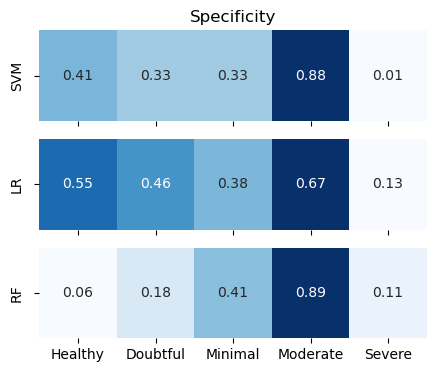

In [21]:
# figure size in inches
rcParams['figure.figsize'] = 5,4

def plot_specificity_chart(data, class_names, title):
    
    svm_model, svm_y_axis = data[0]
    lr_model, lr_y_axis = data[1]
    rf_model, rf_y_axis = data[2]
    
    xlabel = ''
    
    svm = pd.DataFrame(svm_model, index=[xlabel], columns=[None, None, None, None, None])
    lr = pd.DataFrame(lr_model, index=[xlabel], columns=[None, None, None, None, None])
    rf = pd.DataFrame(rf_model, index=[xlabel], columns=class_names)
    
    fig, ax =plt.subplots(3,1)

    smv_chart = sns.heatmap(svm, annot=True, fmt='.2f', cmap='Blues', cbar=False, ax=ax[0])
    smv_chart.get_yaxis().set_label_text('SVM')
    smv_chart.set_title('Specificity')
    
    
    lr_chart = sns.heatmap(lr, annot=True, fmt='.2f', cmap='Blues', cbar=False, ax=ax[1])
    lr_chart.get_yaxis().set_label_text('LR')
    
    
    rf_chart = sns.heatmap(rf, annot=True, fmt='.2f', cmap='Blues', cbar=False, ax=ax[2])
    rf_chart.get_yaxis().set_label_text('RF')
    
    fig.show()
    

    
specificity_chart_data = [(specificity_heatmap_svm, 'SVM'), (specificity_heatmap_lr, 'LR'), (specificity_heatmap_rf, 'RF')]

specificity_charts = plot_specificity_chart(specificity_chart_data, list_of_classes, title='Specificity')

# Image prediction

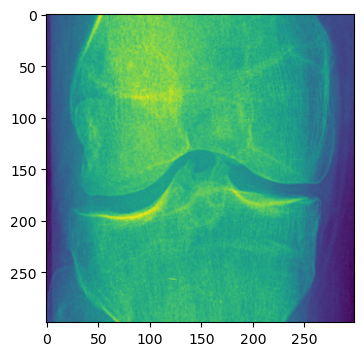

Healthy = 6.0%
Doubtful = 44.0%
Minimal = 21.0%
Moderate = 21.0%
Severe = 8.0%
The predicted knee condition is : Doubtful


In [47]:
from skimage.io import imread 


#doubtful class image
path='/Users/srikanth.goli/Downloads/KneeXrayData/ClsKLData/kneeKL299/train/1/9054866R.png'

img=imread(path) 
plt.imshow(img) 
plt.show() 
l=[img.flatten()] 

probability=rf.predict_proba(l) 
for ind,val in enumerate(list_of_classes): 
    print(f'{val} = {probability[0][ind]*100}%') 
    
print(f"The predicted knee condition is : {list_of_classes[rf.predict(l)[0]]}")

# Data classification

Text(0.5, 1.0, 'Train Data Distribution')

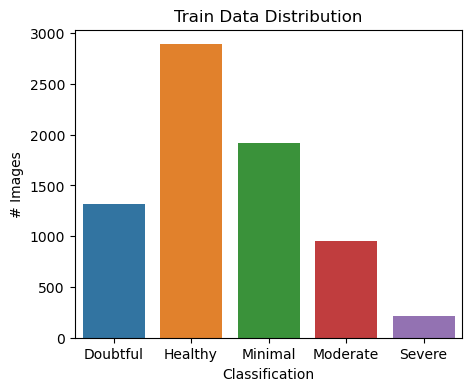

In [75]:
train_df_stats = train_df.groupby(['labels']).size().reset_index(name='Count')

# plot barplot 
train_df_chart = sns.barplot(x="labels", y="Count", data=train_df_stats) 

train_df_chart.set_ylabel('# Images')
train_df_chart.set_xlabel('Classification')
train_df_chart.set_title('Train Data Distribution')

Text(0.5, 1.0, 'Test Data Distribution')

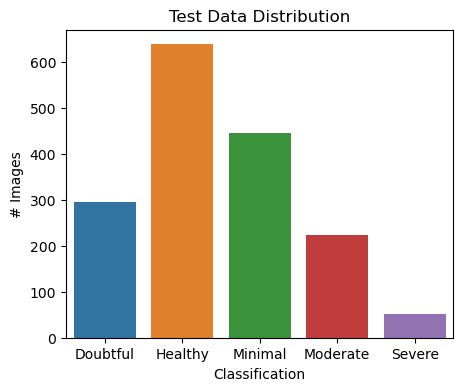

In [74]:

test_df_stats = test_df.groupby(['labels']).size().reset_index(name='Count')
  
# plot barplot 
test_df_chart = sns.barplot(x="labels", y="Count", data=train_df_stats) 

test_df_chart.set_ylabel('# Images')
test_df_chart.set_xlabel('Classification')
test_df_chart.set_title('Test Data Distribution')